In [14]:
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt

In [15]:
# ****************************************************************************
# Simulation Parameters
# ****************************************************************************
SIM_TIME = 43200
NUM_BS = 3
HAPS_CAPACITY = 50

BS_SERVICE_TIME = 5.0
HAPS_SERVICE_TIME = 5.0

BS_BUFFER_CAPACITY = 50
BS_CONGESTION_THRESHOLD = 0.5
hourly_arrival_rates = [0.22, 0.31, 0.37, 0.41, 0.49, 0.52, 0.55, 0.63, 0.69, 0.71, 0.76, 0.82]

USE_HAPS = False

BS_SERVICE_RATE = 1.0 / BS_SERVICE_TIME
HAPS_SERVICE_RATE = 1.0 / HAPS_SERVICE_TIME

In [16]:
# ****************************************************************************
# Data Collection
# ****************************************************************************
class Measure:
    def __init__(self):
        self.total_arrivals = 0
        self.bs_served = [0]*NUM_BS
        self.haps_served = 0
        self.bs_busy_time = [0.0]*NUM_BS
        self.haps_busy_time = 0.0
        self.total_delay = []
        self.haps_delay = []
        self.arrivals_per_hour = [0]*12
        self.haps_served_per_hour = [0]*12
        self.bs_served_per_hour = [0]*12
        self.bs_drops = [0]*NUM_BS
        self.bs_drops_per_hour = [[0]*12 for _ in range(NUM_BS)]


metrics = Measure()

# ****************************************************************************
# Event System
# ****************************************************************************
class Packet:
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time

FES = PriorityQueue()
time = 0.0

haps_buffer = []
bs_buffers = [[] for _ in range(NUM_BS)]
bs_busy = [False]*NUM_BS
haps_busy = False

# ****************************************************************************
# Event Handlers
# ****************************************************************************
def schedule_event(event_time, event_type, payload=None):
    FES.put((event_time, event_type, payload))

def handle_arrival():
    global time
    hour = int(time // 3600) % 12
    lam = hourly_arrival_rates[hour]
    iat = random.expovariate(lam)
    schedule_event(time + iat, "arrival")

    metrics.total_arrivals += 1
    metrics.arrivals_per_hour[hour] += 1
    packet = Packet(time)

    congested = [len(bs_buffers[i]) / BS_BUFFER_CAPACITY for i in range(NUM_BS)]
    underloaded_bs = [i for i in range(NUM_BS) if congested[i] <= BS_CONGESTION_THRESHOLD]

    if underloaded_bs:
        # choose bs less congested
        chosen_index = min(underloaded_bs, key=lambda i: len(bs_buffers[i]))

        if not bs_busy[chosen_index]:
            # bs free => serve
            start_bs_service(chosen_index, packet)
        else:
            # bs occupied => buffer
            bs_buffers[chosen_index].append(packet)
    else:
        # no bs => try haps
        if USE_HAPS and not haps_busy:
            # haps free => serve
            start_haps_service(packet)
        elif USE_HAPS and len(haps_buffer) < HAPS_CAPACITY:
            # haps occupied with space => buffer
            haps_buffer.append(packet)
        else:
            # haps full => pkt lost
            dropped_index = random.randint(0, NUM_BS - 1)
            metrics.bs_drops[dropped_index] += 1
            metrics.bs_drops_per_hour[dropped_index][hour] += 1





def start_haps_service(packet):
    global haps_busy
    haps_busy = True
    service_time = random.expovariate(HAPS_SERVICE_RATE)
    schedule_event(time + service_time, "haps_departure", packet)
    metrics.haps_busy_time += service_time

def handle_haps_departure(packet):
    global haps_busy
    delay = time - packet.arrival_time
    metrics.total_delay.append(delay)
    metrics.haps_delay.append(delay)
    metrics.haps_served += 1
    hour = int(time // 3600) % 12
    metrics.haps_served_per_hour[hour] += 1
    if haps_buffer:
        next_packet = haps_buffer.pop(0)
        start_haps_service(next_packet)
    else:
        haps_busy = False

def start_bs_service(index, packet):
    global bs_busy
    bs_busy[index] = True
    service_time = random.expovariate(BS_SERVICE_RATE)
    schedule_event(time + service_time, f"bs_departure_{index}", packet)
    metrics.bs_busy_time[index] += service_time

def handle_bs_departure(index, packet):
    global bs_busy
    bs_busy[index] = False
    delay = time - packet.arrival_time
    metrics.total_delay.append(delay)
    metrics.bs_served[index] += 1
    hour = int(time // 3600) % 12
    metrics.bs_served_per_hour[hour] += 1
    if bs_buffers[index]:
        next_packet = bs_buffers[index].pop(0)
        start_bs_service(index, next_packet)

In [19]:
# ****************************************************************************
# Main Simulation
# ****************************************************************************
def run_simulation():
    global time
    random.seed(42)
    schedule_event(0, "arrival")

    while not FES.empty() and time < SIM_TIME:
        event_time, event_type, payload = FES.get()
        time = event_time

        if event_type == "arrival":
            handle_arrival()
        elif event_type == "haps_departure":
            handle_haps_departure(payload)
        elif event_type.startswith("bs_departure_"):
            index = int(event_type.split("_")[-1])
            handle_bs_departure(index, payload)

    scenario = "Scenario B (with HAPS)" if USE_HAPS else "Scenario A (BS only)"
    print(f"\n--- Simulation Results: {scenario} ---")
    print(f"Total Arrivals: {metrics.total_arrivals}")
    print(f"HAPS Served: {metrics.haps_served}")
    print(f"HAPS Busy Time: {metrics.haps_busy_time:.2f} seconds")
    total_drops = 0
    total_busy_time = 0
    for i in range(NUM_BS):
        print(f"BS[{i}] Served: {metrics.bs_served[i]}")
        print(f"BS[{i}] Busy Time: {metrics.bs_busy_time[i]:.2f} seconds")
        print(f"BS[{i}] Packet Drops: {metrics.bs_drops[i]}")
        total_drops += metrics.bs_drops[i]
        total_busy_time += metrics.bs_busy_time[i]
    avg_delay = sum(metrics.total_delay)/len(metrics.total_delay)
    avg_bs_busy_time = total_busy_time/NUM_BS
    print(f"Average busy time of BSs: {avg_bs_busy_time:.2f} seconds")
    print(f"Average Total Delay: {avg_delay:.2f} seconds")
    if metrics.haps_delay:
        avg_haps_delay = sum(metrics.haps_delay)/len(metrics.haps_delay)
        print(f"Average HAPS Delay: {avg_haps_delay:.2f} seconds")
    print(f"Total packet drops: {total_drops}")
    if USE_HAPS:
        fraction_haps = metrics.haps_served / metrics.total_arrivals
        print(f"Fraction of traffic handled by HAPS: {fraction_haps:.2%}")

    hours = list(range(8, 20))
    plt.figure(figsize=(12, 6))
    plt.plot(hours, metrics.arrivals_per_hour, label='Total Arrivals', marker='o')
    if USE_HAPS:
        plt.plot(hours, metrics.haps_served_per_hour, label='HAPS Served', marker='x')
    plt.plot(hours, metrics.bs_served_per_hour, label='BSs Served', color='#2ca02c', marker='s')
    plt.xlabel('Hour of Day')
    plt.ylabel('Packets')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #plot arrivals per hour
    '''
    plt.figure(figsize=(8, 5))
    plt.bar(range(8, 20), metrics.arrivals_per_hour, color='blue')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Arrivals')
    plt.title('Arrivals per Hour')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    '''
    
    plt.figure(figsize=(8, 5))
    plt.hist(metrics.total_delay, bins=50, alpha=0.7)
    plt.xlabel('Delay (s)')
    plt.ylabel('Packet Count')
    plt.title('Distribution of Total Queuing and Waiting Delays')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    drops_per_hour = [sum(metrics.bs_drops_per_hour[i][h] for i in range(NUM_BS)) for h in range(12)]
    plt.figure(figsize=(10, 5))
    plt.bar(range(8, 20), metrics.arrivals_per_hour, label='Arrivals per hour')
    plt.bar(range(8, 20), drops_per_hour, label='Drops per hour', color='red')
    plt.xlabel('Hour of Day')
    plt.ylabel('Packets')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    service_rate_total = NUM_BS * BS_SERVICE_RATE
    if USE_HAPS:
        service_rate_total += HAPS_SERVICE_RATE

    hourly_load = [lam / service_rate_total for lam in hourly_arrival_rates]

    plt.figure(figsize=(10, 5))
    plt.plot(range(8, 20), hourly_load, marker='o', linestyle='-', color='purple')
    plt.xlabel('Hour of Day')
    plt.ylabel('Load (\u03bb / \u03bc)')
    plt.title('Hourly System Load')
    plt.axhline(y=1, color='red', linestyle='--', label='System Capacity Limit (Load=1)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #plot utilization x hour
    haps_utilization = [0]*12
    haps_service_time_per_hour = [0]*12

    if metrics.haps_served > 0:
        avg_haps_service_time = metrics.haps_busy_time / metrics.haps_served
        for hour in range(12):
            haps_service_time_per_hour[hour] = metrics.haps_served_per_hour[hour] * avg_haps_service_time
            haps_utilization[hour] = haps_service_time_per_hour[hour] / 3600

    plt.figure(figsize=(10, 5))
    plt.plot(range(8, 20), [u*100 for u in haps_utilization], marker='o', color="#2ca02c")
    plt.xlabel('Hour of Day')
    plt.ylabel('HAPS Utilization (%)')
    plt.title('Hourly HAPS Utilization')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    total_served = metrics.haps_served + sum(metrics.bs_served)
    total_drops = sum(metrics.bs_drops)
    print(f"Total served + dropped: {total_served + total_drops}")
    print(f"Should equal total arrivals: {metrics.total_arrivals}")




--- Simulation Results: Scenario A (BS only) ---
Total Arrivals: 23164
HAPS Served: 0
HAPS Busy Time: 0.00 seconds
BS[0] Served: 8072
BS[0] Busy Time: 39863.01 seconds
BS[0] Packet Drops: 635
BS[1] Served: 7113
BS[1] Busy Time: 35473.06 seconds
BS[1] Packet Drops: 668
BS[2] Served: 5957
BS[2] Busy Time: 30135.86 seconds
BS[2] Packet Drops: 652
Average busy time of BSs: 35157.31 seconds
Average Total Delay: 66.58 seconds
Total packet drops: 1955


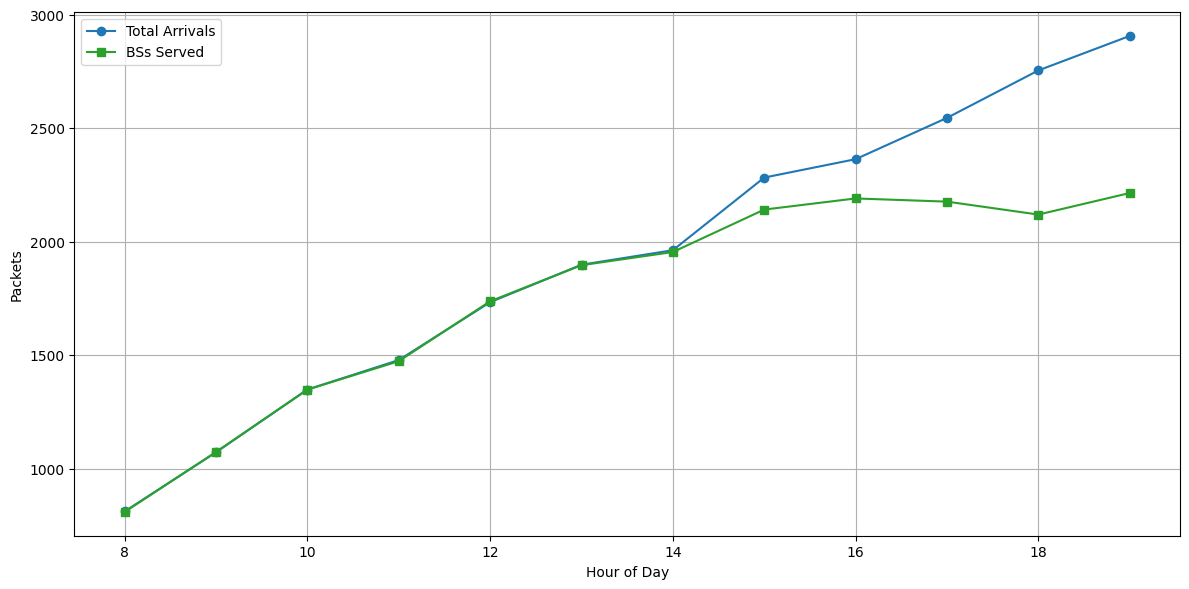

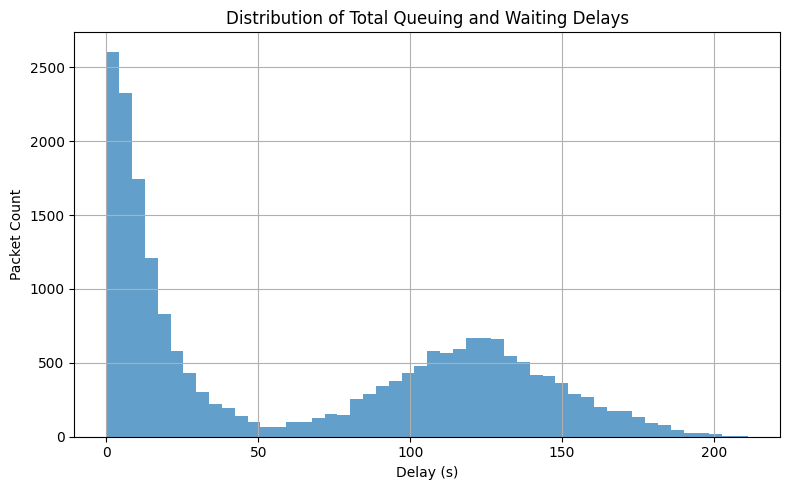

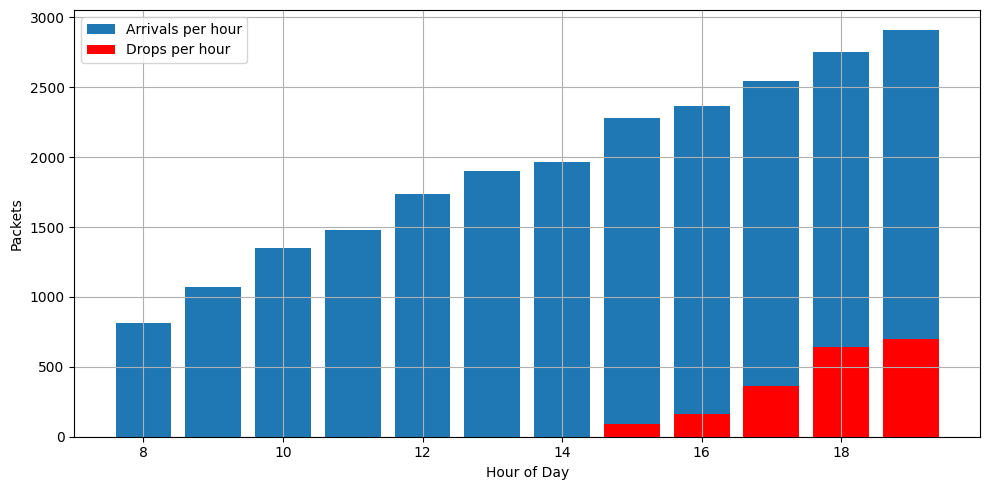

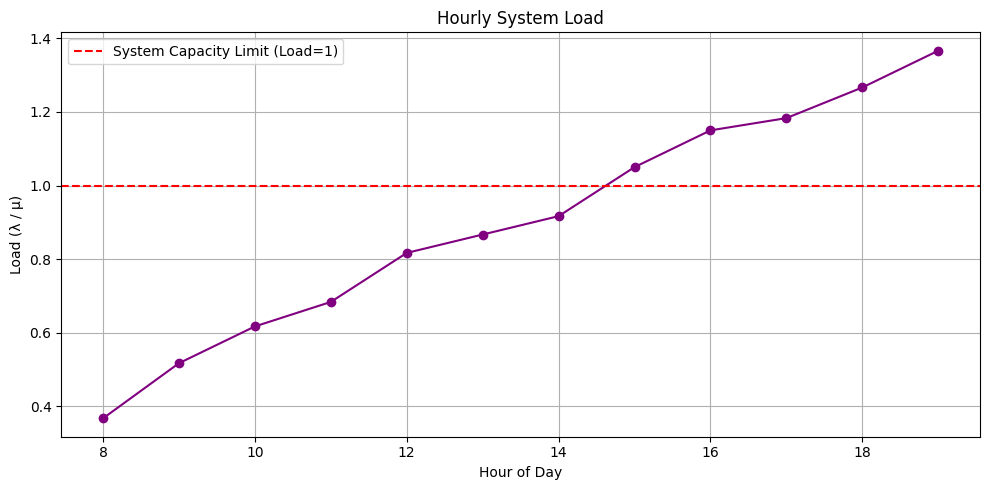

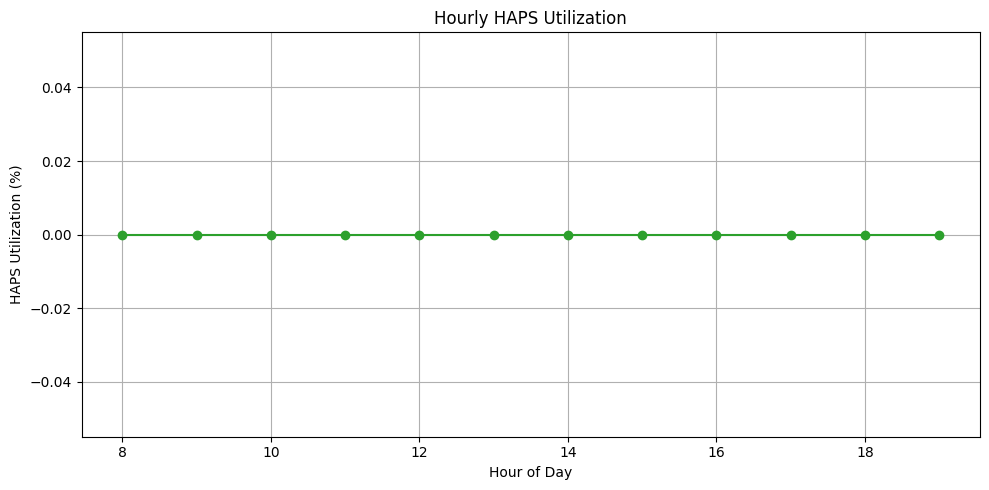

Total served + dropped: 23097
Should equal total arrivals: 23164


In [20]:
if __name__ == "__main__":
    run_simulation()